In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import pandas as pd

# Load the dataset from Parquet file
df = pd.read_parquet('/content/drive/MyDrive/GansData/train-00000-of-00001-b64601da56687a05.parquet')

# Shorten the dataset to 300 images and 100 corresponding text entries
shortened_df = df.head(800)

# Save the shortened dataset to a new Parquet file
# shortened_df.to_parquet('shortened_dataset.parquet')

# Display information about the shortened dataset
print("Shape of shortened dataset:", shortened_df.shape)
print("Column names of shortened dataset:", shortened_df.columns)
print("Sample data from shortened dataset:")
print(shortened_df.head())


Shape of shortened dataset: (800, 2)
Column names of shortened dataset: Index(['image', 'text'], dtype='object')
Sample data from shortened dataset:
                                               image  \
0  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
1  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
2  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
3  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
4  {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   

                                                text  
0  "a logo of coffee shop, take-away coffee cardb...  
1  "a logo of coffee shop, White round background...  
2  "a logo of coffee shop, image of a filled cup ...  
3  "a logo of cafe restaurant bar pizzeria with a...  
4  "a logo of cafe restaurant bar with a circle w...  


In [20]:
shortened_df.iloc[1,1]

'"a logo of coffee shop, White round background with black rim, cup, pretzel, horizontal stripe and cookery lettering, tan background, snow, darkslategray foreground, minimalism, modern"'

In [21]:
!pip install transformers


In [22]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
# used word2vec

In [24]:
#Importing necessary libraries
from keras.models import Model
from keras.layers import Input, Concatenate, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation
from keras.optimizers import Adam
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from PIL import Image
import io

In [25]:

# Load and preprocess images
def load_images(shortened_df):
    images = []
    for i in range(800):
        image_bytes = shortened_df['image'][i]['bytes']  # Accessing the 'bytes' key in the dictionary
        image = load_and_preprocess_image(image_bytes)
        images.append(image)
    return np.array(images)

def load_and_preprocess_image(image_bytes):
    # Open the image from bytes
    img = Image.open(io.BytesIO(image_bytes))

    # Convert to RGB if image mode is RGBA
    if img.mode == 'RGBA':
        img = img.convert('RGB')

    # Resize images to desired dimensions
    img = img.resize((64, 64))

    # Convert to numpy array and normalize pixel values to range [-1, 1]
    img = np.array(img) / 127.5 - 1.0

    return img

# Assuming 'shortened_df' contains image paths in 'image' column
real_images = load_images(shortened_df)



In [26]:
# Train Word2Vec model
tokenized_data = [word_tokenize(text.lower()) for text in shortened_df['text']]
model = Word2Vec(sentences=tokenized_data, vector_size=100, window=5, min_count=1, workers=4)

# Function to get text embedding
def get_text_embedding(text):
    tokens = word_tokenize(text.lower())
    embedding = np.zeros(model.vector_size)
    count = 0
    for token in tokens:
        if token in model.wv:
            embedding += model.wv[token]
            count += 1
    if count != 0:
        embedding /= count
    return embedding

# Get text embeddings for all texts in the dataset
text_embeddings = np.array([get_text_embedding(text) for text in shortened_df['text']])


In [27]:
from keras.layers import UpSampling2D
from keras.layers import LeakyReLU

def build_generator_progressive(model, resolution=4, final_resolution=64):
    input_noise = Input(shape=(100,))
    input_embedding = Input(shape=(model.vector_size,))

    x = Concatenate()([input_noise, input_embedding])
    x = Dense(256 * resolution * resolution)(x)
    x = Reshape((resolution, resolution, 256))(x)

    while resolution < final_resolution:
        x = Conv2DTranspose(128, kernel_size=5, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

        x = Conv2DTranspose(64, kernel_size=5, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

        x = UpSampling2D()(x)  # Upsampling the image resolution
        resolution *= 2

    # Final convolutional layer to generate the output image
    x = Conv2DTranspose(3, kernel_size=5, strides=1, padding='same', activation='tanh')(x)

    model = Model(inputs=[input_noise, input_embedding], outputs=x)
    return model





In [28]:

"""# Generator
def build_generator(model):

    input_noise = Input(shape=(100,))
    input_embedding = Input(shape=(model.vector_size,))

    x = Concatenate()([input_noise, input_embedding])
    x = Dense(256 * 8 * 8)(x)
    x = Reshape((8, 8, 256))(x)

    x = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(x)

    model = Model(inputs=[input_noise, input_embedding], outputs=x)
    return model
"""

"# Generator\ndef build_generator(model):\n\n    input_noise = Input(shape=(100,))\n    input_embedding = Input(shape=(model.vector_size,))\n\n    x = Concatenate()([input_noise, input_embedding])\n    x = Dense(256 * 8 * 8)(x)\n    x = Reshape((8, 8, 256))(x)\n\n    x = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(x)\n    x = BatchNormalization()(x)\n    x = Activation('relu')(x)\n\n    x = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(x)\n    x = BatchNormalization()(x)\n    x = Activation('relu')(x)\n\n    x = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(x)\n\n    model = Model(inputs=[input_noise, input_embedding], outputs=x)\n    return model\n"

In [29]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Flatten, Concatenate, Input, Dense, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def build_discriminator_with_minibatch(input_shape, model):
    input_image = Input(shape=input_shape)
    input_embedding = Input(shape=(model.vector_size,))

    x = Conv2D(64, kernel_size=5, strides=2, padding='same')(input_image)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Flatten the feature maps
    x = Flatten()(x)

    # Minibatch discrimination
    minibatch_features = Dense(100)(x)
    minibatch_features = Reshape((-1, 100))(minibatch_features)
    minibatch_output = Lambda(lambda x: tf.reduce_sum(tf.abs(x[:, None, :, :] - x[:, :, None, :]), axis=3))(minibatch_features)
    x = Concatenate()([x, input_embedding, tf.reduce_mean(minibatch_output, axis=1)])

    # Final output layer
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_image, input_embedding], outputs=x)
    return model

# Example usage:
input_shape = (64, 64, 3)  # Example input shape
discriminator_with_minibatch = build_discriminator_with_minibatch(input_shape, model)
discriminator_with_minibatch.summary()



Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 32, 32, 64)           4864      ['input_13[0][0]']            
                                                                                                  
 batch_normalization_21 (Ba  (None, 32, 32, 64)           256       ['conv2d_12[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_12 (Activation)  (None, 32, 32, 64)           0         ['batch_normalization_21

In [30]:
"""# Discriminator
def build_discriminator(model):
    input_image = Input(shape=(64, 64, 3))
    input_embedding = Input(shape=(model.vector_size,))

    x = Conv2D(64, kernel_size=5, strides=2, padding='same')(input_image)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Flatten()(x)
    x = Concatenate()([x, input_embedding])
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_image, input_embedding], outputs=x)
    return model"""


"# Discriminator\ndef build_discriminator(model):\n    input_image = Input(shape=(64, 64, 3))\n    input_embedding = Input(shape=(model.vector_size,))\n\n    x = Conv2D(64, kernel_size=5, strides=2, padding='same')(input_image)\n    x = BatchNormalization()(x)\n    x = Activation('relu')(x)\n\n    x = Conv2D(128, kernel_size=5, strides=2, padding='same')(x)\n    x = BatchNormalization()(x)\n    x = Activation('relu')(x)\n\n    x = Conv2D(256, kernel_size=5, strides=2, padding='same')(x)\n    x = BatchNormalization()(x)\n    x = Activation('relu')(x)\n\n    x = Conv2D(512, kernel_size=5, strides=2, padding='same')(x)\n    x = BatchNormalization()(x)\n    x = Activation('relu')(x)\n\n    x = Flatten()(x)\n    x = Concatenate()([x, input_embedding])\n    x = Dense(1, activation='sigmoid')(x)\n\n    model = Model(inputs=[input_image, input_embedding], outputs=x)\n    return model"

In [31]:
# Modify the build_cgan function
def build_cgan(generator, discriminator, model):
    noise_input = Input(shape=(100,))
    text_input = Input(shape=(model.vector_size,))
    generated_image = generator([noise_input, text_input])

    # Call discriminator with generated image and text input
    cgan_output = discriminator([generated_image, text_input])

    model = Model(inputs=[noise_input, text_input], outputs=cgan_output)
    return model

# Instantiate models
generator = build_generator_progressive(model)
# Use the previously defined build_discriminator_with_minibatch function
discriminator = build_discriminator_with_minibatch((64, 64, 3), model)
cgan = build_cgan(generator, discriminator, model)

# Compile the models
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
cgan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

# Print model summary
generator.summary()
discriminator.summary()
cgan.summary()



Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 concatenate_6 (Concatenate  (None, 200)                  0         ['input_15[0][0]',            
 )                                                                   'input_16[0][0]']            
                                                                                                  
 dense_10 (Dense)            (None, 4096)                 823296    ['concatenate_6[0][0]'] 

In [32]:
import datetime

2/2 [==============================] - 0s 7ms/step
Epoch 1/500:
    Discriminator Loss: 4.2411693930625916, Generator Loss: 0.3351806104183197
2/2 [==============================] - 0s 12ms/step
Epoch 2/500:
    Discriminator Loss: 5.84472900275432, Generator Loss: 0.09555207192897797
2/2 [==============================] - 0s 10ms/step
Epoch 3/500:
    Discriminator Loss: 1.5903405845165253, Generator Loss: 2.149526596069336
2/2 [==============================] - 0s 10ms/step
Epoch 4/500:
    Discriminator Loss: 5.146876597049413, Generator Loss: 0.09900510311126709
2/2 [==============================] - 0s 11ms/step
Epoch 5/500:
    Discriminator Loss: 0.021649309433996677, Generator Loss: 0.16848844289779663
2/2 [==============================] - 0s 13ms/step
Epoch 6/500:
    Discriminator Loss: 2.030239204876125, Generator Loss: 0.24944010376930237
2/2 [==============================] - 0s 9ms/step
Epoch 7/500:
    Discriminator Loss: 0.1342482939362526, Generator Loss: 0.0006439602

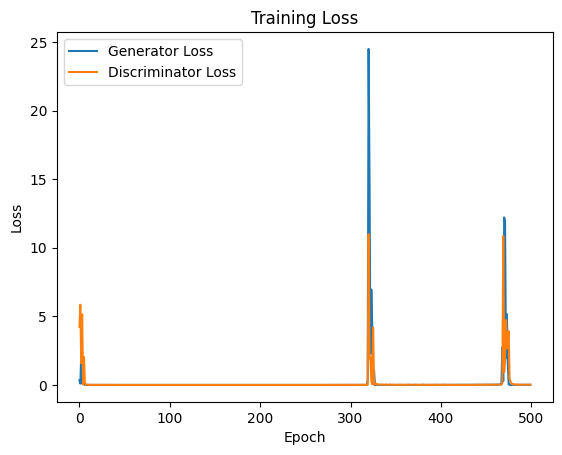

In [33]:
import matplotlib.pyplot as plt

# Training parameters
epochs = 500
batch_size = 64
history = {"generator_loss": [], "discriminator_loss": []}

# Training loop
for epoch in range(epochs):
    # Train discriminator
    # Sample a random batch of real images and text embeddings
    idx = np.random.randint(0, len(real_images), batch_size)
    real_image_batch = real_images[idx]
    text_embedding_batch = text_embeddings[idx]

    # Generate a batch of fake images using random noise and text embeddings
    noise = np.random.randn(batch_size, 100)
    fake_image_batch = generator.predict([noise, text_embedding_batch])

    # Label real and fake images
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train discriminator on real and fake images separately
    real_loss = discriminator.train_on_batch([real_image_batch, text_embedding_batch], real_labels)
    fake_loss = discriminator.train_on_batch([fake_image_batch, text_embedding_batch], fake_labels)

    # Calculate discriminator loss
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)

    # Train generator
    # Generate another batch of fake images
    noise = np.random.randn(batch_size, 100)
    fake_image_batch = generator.predict([noise, text_embedding_batch])

    # Label fake images as real to fool the discriminator
    misleading_labels = np.ones((batch_size, 1))

    # Train generator to generate more realistic images
    generator_loss = cgan.train_on_batch([noise, text_embedding_batch], misleading_labels)

    # Store loss values in history dictionary
    history["generator_loss"].append(generator_loss)
    history["discriminator_loss"].append(discriminator_loss[0])

    # Print training progress
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"    Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {generator_loss}")

# Plot loss curves with adjusted scale
plt.plot(history["generator_loss"], label="Generator Loss")
plt.plot(history["discriminator_loss"], label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.yscale('linear')
plt.legend()
plt.show()


In [34]:
"""# Training parameters
epochs = 325
batch_size = 256

# Training loop
for epoch in range(epochs):
    # Train discriminator
    # Sample a random batch of real images and text embeddings
    idx = np.random.randint(0, len(real_images), batch_size)
    real_image_batch = real_images[idx]
    text_embedding_batch = text_embeddings[idx]

    # Generate a batch of fake images using random noise and text embeddings
    noise = np.random.randn(batch_size, 100)
    fake_image_batch = generator.predict([noise, text_embedding_batch])

    # Label real and fake images
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train discriminator on real and fake images separately
    real_loss = discriminator.train_on_batch([real_image_batch, text_embedding_batch], real_labels)
    fake_loss = discriminator.train_on_batch([fake_image_batch, text_embedding_batch], fake_labels)

    # Calculate discriminator loss
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)

    # Train generator
    # Generate another batch of fake images
    noise = np.random.randn(batch_size, 100)
    fake_image_batch = generator.predict([noise, text_embedding_batch])

    # Label fake images as real to fool the discriminator
    misleading_labels = np.ones((batch_size, 1))

    # Train generator to generate more realistic images
    generator_loss = cgan.train_on_batch([noise, text_embedding_batch], misleading_labels)

    # Print training progress
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"    Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {generator_loss}")
"""


'# Training parameters\nepochs = 325\nbatch_size = 256\n\n# Training loop\nfor epoch in range(epochs):\n    # Train discriminator\n    # Sample a random batch of real images and text embeddings\n    idx = np.random.randint(0, len(real_images), batch_size)\n    real_image_batch = real_images[idx]\n    text_embedding_batch = text_embeddings[idx]\n\n    # Generate a batch of fake images using random noise and text embeddings\n    noise = np.random.randn(batch_size, 100)\n    fake_image_batch = generator.predict([noise, text_embedding_batch])\n\n    # Label real and fake images\n    real_labels = np.ones((batch_size, 1))\n    fake_labels = np.zeros((batch_size, 1))\n\n    # Train discriminator on real and fake images separately\n    real_loss = discriminator.train_on_batch([real_image_batch, text_embedding_batch], real_labels)\n    fake_loss = discriminator.train_on_batch([fake_image_batch, text_embedding_batch], fake_labels)\n\n    # Calculate discriminator loss\n    discriminator_loss = 

In [35]:
# After training, you can save the models if desired
generator.save('generator_model.keras')
discriminator.save('discriminator_model_with_minibatch.keras')

new_filename = 'cgan_model_{timestamp}.keras'.format(timestamp=datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))  # Or any other unique name
cgan.save(new_filename)

In [36]:
import matplotlib.pyplot as plt
from keras.models import load_model

In [37]:
def generate_image_from_prompt(generator, model, prompt_text):
    # Tokenize the prompt text and get its embedding
    prompt_tokens = word_tokenize(prompt_text.lower())
    prompt_embedding = np.zeros(model.vector_size)
    count = 0
    for token in prompt_tokens:
        if token in model.wv:
            prompt_embedding += model.wv[token]
            count += 1
    if count != 0:
        prompt_embedding /= count

    # Generate random noise as input to the generator
    noise_input = np.random.randn(1, 100)

    # Reshape prompt embedding to match the expected input shape
    prompt_embedding_input = np.tile(prompt_embedding, (1, 1))

    # Generate the image using the generator model
    generated_image = generator.predict([noise_input, prompt_embedding_input])

    # Denormalize the generated image
    generated_image = (generated_image + 1) * 127.5
    generated_image = generated_image.astype(np.uint8)

    # Visualize the generated image
    generated_image = Image.fromarray(generated_image[0])
    plt.imshow(generated_image)
    plt.axis('off')
    plt.show()


1/1 [==============================] - 1s 654ms/step


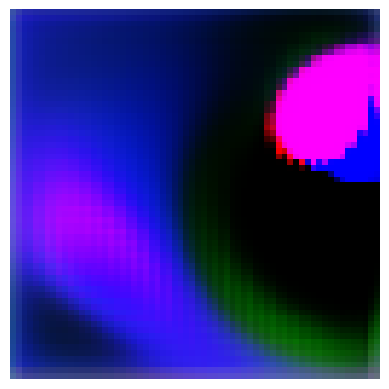

In [38]:
prompt_text = "a logo of coffee shop, White round background with black rim, cup, pretzel, horizontal stripe and cookery lettering, tan background, snow, darkslategray foreground, minimalism, modern"

# Generate an image based on the prompt
generate_image_from_prompt(generator, model, prompt_text)


Now we'll train with 300 epochs

2/2 [==============================] - 0s 7ms/step
Epoch 1/300:
    Discriminator Loss: 0.011861723382025957, Generator Loss: 0.007630730513483286
2/2 [==============================] - 0s 7ms/step
Epoch 2/300:
    Discriminator Loss: 0.013782786205410957, Generator Loss: 0.006831739097833633
2/2 [==============================] - 0s 7ms/step
Epoch 3/300:
    Discriminator Loss: 0.014169752597808838, Generator Loss: 0.007063954137265682
2/2 [==============================] - 0s 7ms/step
Epoch 4/300:
    Discriminator Loss: 0.01651772018522024, Generator Loss: 0.007368255406618118
2/2 [==============================] - 0s 7ms/step
Epoch 5/300:
    Discriminator Loss: 0.012875137850642204, Generator Loss: 0.007672227919101715
2/2 [==============================] - 0s 7ms/step
Epoch 6/300:
    Discriminator Loss: 0.013042674865573645, Generator Loss: 0.00738357100635767
2/2 [==============================] - 0s 6ms/step
Epoch 7/300:
    Discriminator Loss: 0.018441660329699516, Generator 

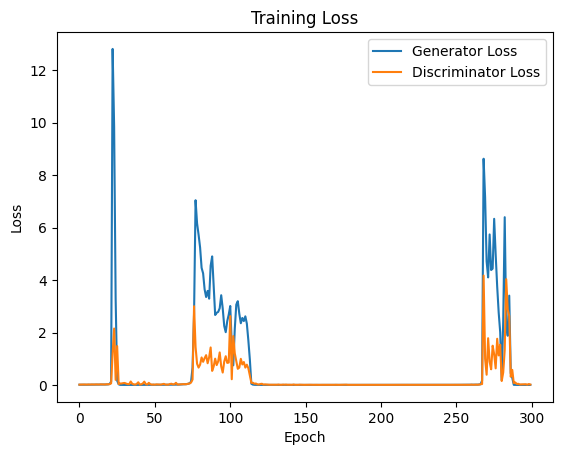

In [39]:
import matplotlib.pyplot as plt

# Training parameters
epochs = 300
batch_size = 64
history = {"generator_loss": [], "discriminator_loss": []}

# Training loop
for epoch in range(epochs):
    # Train discriminator
    # Sample a random batch of real images and text embeddings
    idx = np.random.randint(0, len(real_images), batch_size)
    real_image_batch = real_images[idx]
    text_embedding_batch = text_embeddings[idx]

    # Generate a batch of fake images using random noise and text embeddings
    noise = np.random.randn(batch_size, 100)
    fake_image_batch = generator.predict([noise, text_embedding_batch])

    # Label real and fake images
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train discriminator on real and fake images separately
    real_loss = discriminator.train_on_batch([real_image_batch, text_embedding_batch], real_labels)
    fake_loss = discriminator.train_on_batch([fake_image_batch, text_embedding_batch], fake_labels)

    # Calculate discriminator loss
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)

    # Train generator
    # Generate another batch of fake images
    noise = np.random.randn(batch_size, 100)
    fake_image_batch = generator.predict([noise, text_embedding_batch])

    # Label fake images as real to fool the discriminator
    misleading_labels = np.ones((batch_size, 1))

    # Train generator to generate more realistic images
    generator_loss = cgan.train_on_batch([noise, text_embedding_batch], misleading_labels)

    # Store loss values in history dictionary
    history["generator_loss"].append(generator_loss)
    history["discriminator_loss"].append(discriminator_loss[0])

    # Print training progress
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"    Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {generator_loss}")

# Plot loss curves with adjusted scale
plt.plot(history["generator_loss"], label="Generator Loss")
plt.plot(history["discriminator_loss"], label="Discriminator Loss")
plt.yscale('linear')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()


In [40]:
# After training, you can save the models if desired
generator.save('generator_model.keras')
discriminator.save('discriminator_model_with_minibatch.keras')

new_filename = 'cgan_model_{timestamp}.keras'.format(timestamp=datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))  # Or any other unique name
cgan.save(new_filename)

In [41]:
import matplotlib.pyplot as plt
from keras.models import load_model

def generate_image_from_prompt(generator, model, prompt_text):
    # Tokenize the prompt text and get its embedding
    prompt_tokens = word_tokenize(prompt_text.lower())
    prompt_embedding = np.zeros(model.vector_size)
    count = 0
    for token in prompt_tokens:
        if token in model.wv:
            prompt_embedding += model.wv[token]
            count += 1
    if count != 0:
        prompt_embedding /= count

    # Generate random noise as input to the generator
    noise_input = np.random.randn(1, 100)

    # Reshape prompt embedding to match the expected input shape
    prompt_embedding_input = np.tile(prompt_embedding, (1, 1))

    # Generate the image using the generator model
    generated_image = generator.predict([noise_input, prompt_embedding_input])

    # Denormalize the generated image
    generated_image = (generated_image + 1) * 127.5
    generated_image = generated_image.astype(np.uint8)

    # Visualize the generated image
    generated_image = Image.fromarray(generated_image[0])
    plt.imshow(generated_image)
    plt.axis('off')
    plt.show()


1/1 [==============================] - 0s 23ms/step


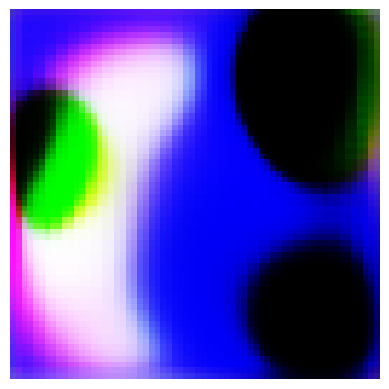

In [42]:
prompt_text = "a logo of coffee shop, White round background with black rim, cup, pretzel, horizontal stripe and cookery lettering, tan background, snow, darkslategray foreground, minimalism, modern"

# Generate an image based on the prompt
generate_image_from_prompt(generator, model, prompt_text)


Now, we'll train with 100 epochs

2/2 [==============================] - 0s 10ms/step
Epoch 1/100:
    Discriminator Loss: 0.014944784808903933, Generator Loss: 0.0007480161730200052
2/2 [==============================] - 0s 7ms/step
Epoch 2/100:
    Discriminator Loss: 0.008330938871949911, Generator Loss: 0.0008746583480387926
2/2 [==============================] - 0s 7ms/step
Epoch 3/100:
    Discriminator Loss: 0.005324315628968179, Generator Loss: 0.0009860198479145765
2/2 [==============================] - 0s 7ms/step
Epoch 4/100:
    Discriminator Loss: 0.009962097276002169, Generator Loss: 0.0011926231672987342
2/2 [==============================] - 0s 7ms/step
Epoch 5/100:
    Discriminator Loss: 0.007241340354084969, Generator Loss: 0.0013265134766697884
2/2 [==============================] - 0s 7ms/step
Epoch 6/100:
    Discriminator Loss: 0.01475837011821568, Generator Loss: 0.0013032545102760196
2/2 [==============================] - 0s 11ms/step
Epoch 7/100:
    Discriminator Loss: 0.006826824974268675, G

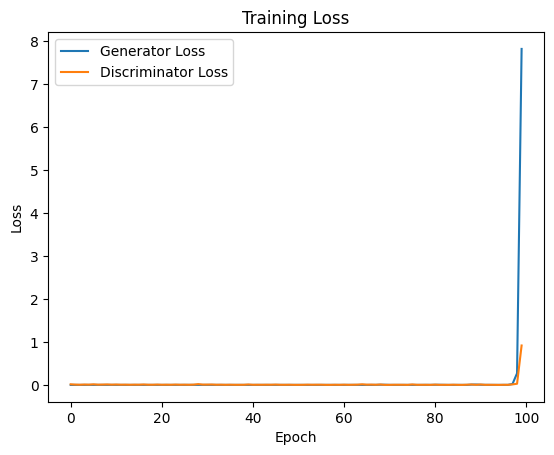

In [43]:
import matplotlib.pyplot as plt

# Training parameters
epochs = 100
batch_size = 64
history = {"generator_loss": [], "discriminator_loss": []}

# Training loop
for epoch in range(epochs):
    # Train discriminator
    # Sample a random batch of real images and text embeddings
    idx = np.random.randint(0, len(real_images), batch_size)
    real_image_batch = real_images[idx]
    text_embedding_batch = text_embeddings[idx]

    # Generate a batch of fake images using random noise and text embeddings
    noise = np.random.randn(batch_size, 100)
    fake_image_batch = generator.predict([noise, text_embedding_batch])

    # Label real and fake images
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train discriminator on real and fake images separately
    real_loss = discriminator.train_on_batch([real_image_batch, text_embedding_batch], real_labels)
    fake_loss = discriminator.train_on_batch([fake_image_batch, text_embedding_batch], fake_labels)

    # Calculate discriminator loss
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)

    # Train generator
    # Generate another batch of fake images
    noise = np.random.randn(batch_size, 100)
    fake_image_batch = generator.predict([noise, text_embedding_batch])

    # Label fake images as real to fool the discriminator
    misleading_labels = np.ones((batch_size, 1))

    # Train generator to generate more realistic images
    generator_loss = cgan.train_on_batch([noise, text_embedding_batch], misleading_labels)

    # Store loss values in history dictionary
    history["generator_loss"].append(generator_loss)
    history["discriminator_loss"].append(discriminator_loss[0])

    # Print training progress
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"    Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {generator_loss}")

# Plot loss curves with adjusted scale
plt.plot(history["generator_loss"], label="Generator Loss")
plt.plot(history["discriminator_loss"], label="Discriminator Loss")
plt.yscale('linear')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()


In [44]:
# After training, you can save the models if desired
generator.save('generator_model.keras')
discriminator.save('discriminator_model_with_minibatch.keras')

new_filename = 'cgan_model_{timestamp}.keras'.format(timestamp=datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))  # Or any other unique name
cgan.save(new_filename)

In [45]:
import matplotlib.pyplot as plt
from keras.models import load_model

def generate_image_from_prompt(generator, model, prompt_text):
    # Tokenize the prompt text and get its embedding
    prompt_tokens = word_tokenize(prompt_text.lower())
    prompt_embedding = np.zeros(model.vector_size)
    count = 0
    for token in prompt_tokens:
        if token in model.wv:
            prompt_embedding += model.wv[token]
            count += 1
    if count != 0:
        prompt_embedding /= count

    # Generate random noise as input to the generator
    noise_input = np.random.randn(1, 100)

    # Reshape prompt embedding to match the expected input shape
    prompt_embedding_input = np.tile(prompt_embedding, (1, 1))

    # Generate the image using the generator model
    generated_image = generator.predict([noise_input, prompt_embedding_input])

    # Denormalize the generated image
    generated_image = (generated_image + 1) * 127.5
    generated_image = generated_image.astype(np.uint8)

    # Visualize the generated image
    generated_image = Image.fromarray(generated_image[0])
    plt.imshow(generated_image)
    plt.axis('off')
    plt.show()


1/1 [==============================] - 0s 22ms/step


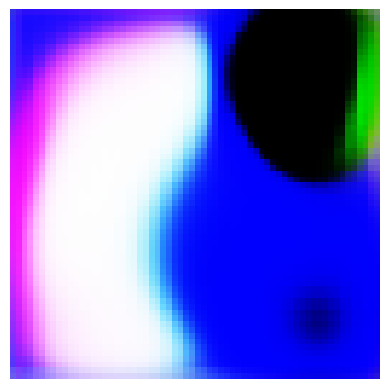

In [46]:
prompt_text = "a logo of coffee shop, White round background with black rim, cup, pretzel, horizontal stripe and cookery lettering, tan background, snow, darkslategray foreground, minimalism, modern"

# Generate an image based on the prompt
generate_image_from_prompt(generator, model, prompt_text)
